In [8]:
import torch
import torch.nn as nn
from torchvision import datasets, models
import torch.utils.data as data
import random
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import torch.optim as optim
import math
import torchvision.transforms as transforms

data_root = 'data/celeba'

celeba_data = datasets.CelebA(data_root, download=False)

In [9]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
class CelebAPairsDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, download=True):
        self.dataset = datasets.CelebA(data_root, download=download, transform=transform)

        self.male_smiling_indices = []
        self.male_not_smiling_indices = []
        self.female_smiling_indices = []
        self.female_not_smiling_indices = []

        self.pairs = [] # index1, index2, pos


        for i in range(len(self.dataset)):
            if self.dataset.attr[i][20] == 1 and self.dataset.attr[i][31] == 1: # smiling male
                self.male_smiling_indices.append(i)
            elif self.dataset.attr[i][20] == 1 and self.dataset.attr[i][31] == 0: # not smiling male
                self.male_not_smiling_indices.append(i)
            elif self.dataset.attr[i][20] == 0 and self.dataset.attr[i][31] == 1: # smiling female
                self.female_smiling_indices.append(i)
            elif self.dataset.attr[i][20] == 0 and self.dataset.attr[i][31] == 0: # not smiling female
                self.female_not_smiling_indices.append(i)

        
        # generate initial random pairs
        for i in range(self.__len__()): # look into number of pairs
            positive = 0
            if random.random() > 0.5: # positive match
                if random.random() > 0.5: # both smiling
                    img1_index, img2_index = random.choice(self.male_smiling_indices), random.choice(self.female_smiling_indices)
                else: # both not smiling
                    img1_index, img2_index = random.choice(self.male_not_smiling_indices), random.choice(self.female_not_smiling_indices)
                positive = 1
            else: # negative match
                # img1_index, img2_index = random.sample(self.not_smiling_indices, 2)
                if random.random() > 0.5:
                    img1_index, img2_index = random.choice(self.male_smiling_indices), random.choice(self.female_not_smiling_indices)
                else:
                    img1_index, img2_index = random.choice(self.female_smiling_indices), random.choice(self.male_not_smiling_indices)

            img1, _ = self.dataset[img1_index]
            img2, _ = self.dataset[img2_index]

            self.pairs.append([img1, img2, positive])

    def is_male(self, index):
        return index in self.male_not_smiling_indices or index in self.male_smiling_indices

    def is_smiling(self, index):
        return index in self.male_smiling_indices or index in self.female_smiling_indices

    def get_pair(self, index):
        return self.pairs[index]

    def __len__(self):
        return min(len(self.male_smiling_indices), len(self.male_not_smiling_indices), len(self.female_smiling_indices), len(self.female_not_smiling_indices))

    def __getitem__(self, index):
        return self.pairs[index]


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
celeba_data = CelebAPairsDataset(data_root, download=False)
celeba_loader = torch.utils.data.DataLoader(celeba_data, batch_size=16, shuffle=True)

In [13]:
celeba_data.dataset.attr_names[31]
celeba_data.dataset.attr_names[20]

'Male'

positive: tensor(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


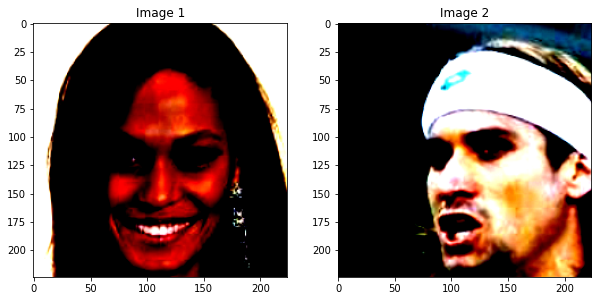

In [14]:
# Get a batch of pairs from the data loader
batch = next(iter(celeba_loader))

# Extract a single pair of images from the batch
img1, img2, pos = batch[0][0], batch[1][0], batch[2][0]

print('positive: ' + str(pos))

# Convert the PyTorch tensors to numpy arrays
img1 = img1.numpy().transpose(1, 2, 0)
img2 = img2.numpy().transpose(1, 2, 0)

# Plot the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[0].set_title("Image 1")
ax[1].set_title("Image 2")
plt.show()

In [15]:
model = models.alexnet(pretrained=False, num_classes=128)
model = model.to(device)

/u/savo5444/.conda/envs/phd9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/u/savo5444/.conda/envs/phd9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
# loss funcions
def cosine_similarity( x1, x2 ):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
    return cos(x1, x2)

tau = 0.05 # from their code

def loss_fn(x1, x2, x2_samples, y_samples):
    # print('x1:')
    # print(x1.shape)
    # print('x2:')
    # print(x2.shape)
    # print('y_samples:')
    # print(y_samples.shape)
    # print('x2 samples:')
    # print(x2_samples.shape)

    sim = cosine_similarity(x1, x2)
    e_term = torch.exp(sim / tau)
    
    sigma_term = 0

    for i in range(len(y_samples)):
        if y_samples[i].item() == 1: # skip positive pairs
            continue
        sigma_term = sigma_term + torch.exp(cosine_similarity(x1, model(x2_samples[i].unsqueeze(0).to(device))) / tau)

    return -torch.log(e_term / (e_term + sigma_term))

In [17]:
def train_loop(dataloader, model, optimizer):
    running_loss = 0.
    last_loss = 0.
    image_i = 0

    for batch, (x1_samples, x2_samples, y_samples) in enumerate(dataloader):

        for i in range(len(y_samples)):
            x1, x2, y = x1_samples[i].to(device), x2_samples[i].to(device), y_samples[i].to(device)
            # print('Y Shape:')
            # print(y_samples.shape)

            # print('x1 samples Shape:')
            # print(x1_samples.shape)

            # print('x2 samples shape:')
            # print(x2_samples.shape)

            if y.item() == 0: # skip negative pairs
                continue
        
            # Compute prediction and loss
            model.train()
            output1 = model(x1.unsqueeze(0)).to(device)
            output2 = model(x2.unsqueeze(0)).to(device)

            loss = loss_fn(output1, output2, x2_samples, y_samples).to(device)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if image_i % 1000 == 0:
                last_loss = running_loss / 1000
                # print('  pairs {} loss: {}'.format(image_i + 1, last_loss))
                running_loss = 0.
            
            image_i += 1

    return last_loss

In [18]:
def dist(output1, output2):
    distance = torch.norm(output2 - output1)
    return distance

In [19]:
def update_match_pairs():
    for i in range(len(celeba_data.pairs)): # for each anchor pair
        pair = celeba_data.get_pair(i)
        x1 = pair[0].to(device) # anchor
        output1 = model(x1.unsqueeze(0)).squeeze(0)
        
        if pair[2] == 0: # skip negative pairs
            continue

        is_smiling = celeba_data.is_smiling(i)

        min_dist = 999
        new_sample = None

        # for k in range(len(celeba_data.pairs)): # for each pair except anchor and different classes
        for k in range(10): # 10 for the demo
            if i == k or is_smiling != celeba_data.is_smiling(k): # skip anchor and non same class
                continue

            p = celeba_data.get_pair(i)
            x3, x4 = p[0].to(device), p[1].to(device)

            output3 = model(x3.unsqueeze(0)).squeeze(0)
            output4 = model(x4.unsqueeze(0)).squeeze(0)
                
            d1 = dist(output1, output3)
            d2 = dist(output1, output4)

            if d1 < min_dist:
                min_dist = d1
                new_sample = x3
            
            if d2 < min_dist:
                min_dist = d2
                new_sample = x4
        
        celeba_data.pairs[i][1] = new_sample.cpu()# replace second sample

In [20]:
epochs = 10
optimizer = optim.SGD(model.parameters(), lr=0.001)

running_loss = 0.


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(celeba_loader, model, optimizer)
    print('Epoch {} loss: {}'.format(t + 1, loss))
    running_loss += loss
    print('Running loss: {}'.format(running_loss / (t + 1)))
    

    if t % 2 == 0:
        # print('Updating match pairs...') # update match pairs
        update_match_pairs()
        print('Match pairs updated.')

    # test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Epoch 1 loss: 2.0091801294982434
Running loss: 2.0091801294982434
Match pairs updated.
Epoch 2
-------------------------------
Epoch 2 loss: 1.2992919693244622
Running loss: 1.6542360494113528
Epoch 3
-------------------------------
Epoch 3 loss: 1.0160838237759018
Running loss: 1.4415186408662024
Match pairs updated.
Epoch 4
-------------------------------
Epoch 4 loss: 0.011093031051875016
Running loss: 1.0839122384126205
Epoch 5
-------------------------------
Epoch 5 loss: 0.015930626325165134
Running loss: 0.8703159159951295
Match pairs updated.
Epoch 6
-------------------------------
Epoch 6 loss: 0.0030656694645185495
Running loss: 0.7257742082400277
Epoch 7
-------------------------------
Epoch 7 loss: 0.004360284757895329
Running loss: 0.6227150763140088


KeyboardInterrupt: 